* 유사도 높은 센서 찾기(12, 16)
* 현 시점에서 트렌드가 증가하는지 감소하는지 어떻게 알까?
* 온도가 time lag에 영향을 받는다면, 
* 온도에 기민하게 반응하는 센서 / 둔감한 센서
* 전날 똑같은 시간대 보다 증/감..?
* 온도값차이가 많이 나는 구간만 체크.기준은?
* feature selection
* 2d 그림처럼 접근..?

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
# !pip install arviz==0.6.0
import arviz as az
import warnings
import seaborn as sns
from itertools import combinations as comb
warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')

     |████████████████████████████████| 1.4MB 4.8MB/s 
     |████████████████████████████████| 4.1MB 47.4MB/s 
     |████████████████████████████████| 317kB 46.2MB/s 


In [0]:
train = pd.read_csv('/content/drive/My Drive/dacon/temp/train.csv')
test = pd.read_csv('/content/drive/My Drive/dacon/temp/test.csv')
sample = pd.read_csv('/content/drive/My Drive/dacon/temp/sample_submission.csv')
data = pd.concat([train.iloc[:,:],test], join='outer')
data = data.reset_index(drop=True)

# time 변수 추가 - partition고려

data['day'] = np.repeat(np.arange(1,114),6*24)
data['hour'] = np.tile(np.repeat(np.arange(1,25),6),113)
data['miniute'] = np.tile(np.arange(1,(6*24)+1),113)
# data['day/night'] = np.where((data['hour']>6) & (data['hour']<19) ,0,1)
# data['peak'] = np.where((data['hour']<17) & (data['hour']>4) ,0,1) # 정점이 대개 16~17임

train['day'] = np.repeat(np.arange(1,34),6*24)
train['hour'] = np.tile(np.repeat(np.arange(1,25),6),33)
train['miniute'] = np.tile(np.arange(1,(6*24)+1),33)
# train['day/night'] = np.where((train['hour']>6) & (train['hour']<19) ,0,1)
# train['peak'] = np.where((train['hour']<17) & (train['hour']>4) ,0,1)

# 최적화.
minute = ((data['id']-19)%144).astype(int)
minute_sin = np.sin(np.pi*minute/(6*24)) 
data['m'] = minute_sin

# 변수제거
data = data.drop(columns=list(data.columns[data.std()==0]))

# sensor list
sensor_list = list(train.columns[41:60])

In [0]:
data['mm'] = data['X00'] - data['m']

In [0]:
def diff_func(DF, feature_list, period):
  '''
  time series diff function
  '''
  df = DF.copy()
  glob_list = ['X04', 'X10', 'X21', 'X36', 'X39','X11','X14', 'X16', 'X19', 'X34']
  for i in feature_list:
    diff = df[i].values - df[i].shift(period).values
    if i not in glob_list:
      df['diff_'+str(period)+'{}'.format(i)] = diff
      df['diff_'+str(period)+'{}'.format(i)] = np.where(df['diff_'+str(period)+'{}'.format(i)]<0 , 0 , df['diff_'+str(period)+'{}'.format(i)])      
    else :
      df['diff_'+str(period)+'{}'.format(i)] = diff

  return df

In [0]:
data['mean_temp'] = data[['X00','X07','X28','X31','X32']].mean(axis=1)
data['std_temp'] = data[['X00','X07','X28','X31','X32']].std(axis=1)
data['mean_rain'] = data[['X04', 'X10', 'X21', 'X36', 'X39']].mean(axis=1)
data['mean_sun'] = data[['X11', 'X14', 'X16', 'X19', 'X34']].mean(axis=1)
data['mean_pre'] = data[['X01', 'X06', 'X22', 'X27', 'X29']].mean(axis=1)
data['mean_wind'] = data[['X02', 'X03', 'X18', 'X24', 'X26']].mean(axis=1)
data['mean_wind2'] = data[['X13', 'X15', 'X17', 'X25', 'X35']].mean(axis=1)
data['mean_humid'] = data[['X12', 'X20', 'X30', 'X37', 'X38']].mean(axis=1)
data['rolling6_mean'] = data['mean_temp'].rolling(6).mean()
data['max-min_daily'] = data['mean_temp'].rolling(6*24).max() - data['mean_temp'].rolling(6*24).min()
data['max-min_4h'] = data['mean_temp'].rolling(6*4).max() - data['mean_temp'].rolling(6*4).min()
data['diff_1t'] = data['mean_temp'] - data['mean_temp'].shift(1)
data['diff_2t'] = data['mean_temp'] - data['mean_temp'].shift(2)
data['diff_3t'] = data['mean_temp'] - data['mean_temp'].shift(3)
data['diff_4t'] = data['mean_temp'] - data['mean_temp'].shift(4)
data['diff_5t'] = data['mean_temp'] - data['mean_temp'].shift(5)
data['diff_1h'] = data['mean_temp'] - data['mean_temp'].shift(6)
data['diff_1h_std'] = data['mean_temp'].rolling(6).std()
data['diff_2h'] = data['mean_temp'] - data['mean_temp'].shift(6*2)
data['diff_3h'] = data['mean_temp'] - data['mean_temp'].shift(6*3)
data['diff_4h'] = data['mean_temp'] - data['mean_temp'].shift(6*4)
data['diff_4h_std'] = data['mean_temp'].rolling(6*4).std()
data['diff_24h'] = data['mean_temp'] - data['mean_temp'].shift(6*24) # 아마 trend.
data['cumsum_24h'] = data['mean_temp'] - np.tile(data['mean_temp'][:6*24].values,113)
data['diff_std_1t'] = data['std_temp'] - data['std_temp'].shift(1)
data['diff_std_2t'] = data['std_temp'] - data['std_temp'].shift(2)
data['diff_std_4t'] = data['std_temp'] - data['std_temp'].shift(4)
data['diff_std_1h'] = data['std_temp'] - data['std_temp'].shift(6)
data['diff_std_2h'] = data['std_temp'] - data['std_temp'].shift(6*2)
data['diff_std_4h'] = data['std_temp'] - data['std_temp'].shift(6*4)


# 일사량 / 강수
data = diff_func(data,['mean_sun'],1)
data = diff_func(data,['mean_rain'],1)
data = diff_func(data,['diff_1mean_sun'],1)
data = diff_func(data,['X12', 'X20', 'X30', 'X37', 'X38'],1)
  

# 누적 강수 12시간
data['12h_rain'] = data['mean_rain'].rolling(6*12).sum()

col = comb(['X00','X07','X28','X31','X32'],2)
for i in col:
  data[i[0]+i[1]] = data[i[0]] - data[i[1]]
  data[i[0]+i[1]+'4h_corr'] = data[[i[0],i[1]]].rolling(6*4).corr().iloc[:,0][1::2].values
  data[i[0]+i[1]+'1h_corr'] = data[[i[0],i[1]]].rolling(6).corr().iloc[:,0][1::2].values
  data[i[0]+i[1]+'12h_corr'] = data[[i[0],i[1]]].rolling(6*12).corr().iloc[:,0][1::2].values
  data[i[0]+i[1]+'24h_corr'] = data[[i[0],i[1]]].rolling(6*24).corr().iloc[:,0][1::2].values

for i in ['X00','X07','X28','X31','X32']:
  data['mean-' + i] = data['mean_temp'] - data[i]


for i in ['X00X07',	'X00X28',	'X00X31'	,'X00X32',	'X07X28',	'X07X31',	'X07X32',	'X28X31',	'X28X32',	'X31X32']:
  data[i+'diff1t'] = data[i] - data[i].shift(1)
  data[i+'diff2t'] = data[i] - data[i].shift(2)
  data[i+'diff3t'] = data[i] - data[i].shift(3)
  data[i+'diff1h'] = data[i] - data[i].shift(6)
  data[i+'diff2h'] = data[i] - data[i].shift(6*2)
  data[i+'diff4h'] = data[i] - data[i].shift(6*4)
  


In [0]:
# panel dataset
df = pd.melt(data,
        id_vars='id',
        value_vars=list(train.columns[41:60]), var_name='sensor')

df = pd.merge(df,data.drop(columns=sensor_list), on='id' ) # 합치기.
df = df.dropna() # 결측제거.

test = data[df.drop(columns=['sensor','value']).columns]
test['sensor']=18
test = test.iloc[4752:,:]


In [0]:
# df['diff_temp'] = df['mean_temp'] - df['value']
sensor_lookup = dict(zip(df['sensor'].unique(), range(df['sensor'].nunique())))
df['sensor'] = df['sensor'].replace(sensor_lookup).values

# plt.scatter(df['mean_temp'], df['diff_temp'], alpha=0.05)
# a = df.loc[df['sensor']=='Y10']
# plt.scatter(a['mean_temp/'], a['diff_temp'])
# plt.scatter(a['hour'], a['diff_temp'])
# plt.scatter(a.loc[a['peak']==1]['mean_temp'], a.loc[a['peak']==1]['diff_temp'])
# plt.scatter(a.loc[a['peak']==1]['mean_temp'], a.loc[a['peak']==1]['diff_temp'])

In [0]:
# train['lag1t'] = train['X00'].shift()
# train['lag2t'] = train['X00'].shift(2)
# train['lag3t'] = train['X00'].shift(3)
# train['lag1h'] = train['X00'].shift(6)
# train['lag2h'] = train['X00'].shift(6*2)
# train['lag4h'] = train['X00'].shift(6*4)
# train = train[['X00','lag1t','lag2t','lag3t','lag1h','lag2h','lag4h']].dropna()
# test = train.iloc[-432:,:]
# train = train.iloc[:-432,:]

# X = train.iloc[:,1:]
# Y = train['X00']

In [0]:
Y = train.loc[:,'Y00':'Y10'][1:4300]
X = train.loc[:,'Y00':'Y10'].shift()[1:4300]

# N = 10000
# a = np.array([1, -2]) # 개수.
# b = np.array([[0.5, -0.3],[-0.3, 1.]]) # cov??
# x = np.random.multivariate_normal(a, b, size=N)
# var, U = np.linalg.eig(b)
# angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=11,
                                 eta=11., sd_dist=pm.HalfCauchy.dist(2.5))
with model:
    L = pm.expand_packed_triangular(11, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))
with model:
    μ = pm.Normal('μ', 5., 10, shape=11,
                  testval=X.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=Y.values)


In [0]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [μ, packed_L]
 89%|████████▉ | 893/1000 [29:04<06:40,  3.75s/it]

In [0]:
pm.summary(trace)

## pymc

In [0]:
df = df.loc[df['sensor'].isin([18,16])]
uniq = df.groupby(['sensor','cycle']).size().reset_index().rename(columns={0:'uniq'})
uniq['uniq'] = np.arange(len(uniq))
df = pd.merge(df,uniq,on=['sensor','cycle'])

In [0]:
# value ~ mean_temp + mean_pre + mean_wind + diff_1mean_sun + diff_1mean_rain + beta
X = df[['mean_temp','mean_pre','mean_wind','diff_1mean_sun','diff_1mean_rain']]
X = np.asarray(X)


uniqn = df['uniq'].values
n_dimension = X.shape[1]
n_category = len(np.unique(uniqn))

with pm.Model() as model:
    beta_mu = pm.Normal('beta_mu', 0., 10., shape=6)
    beta_sd = pm.HalfCauchy('beta_sd', 10., shape=6)
    
    # beta0
    alpha = pm.Normal('alpha', mu=beta_mu[0], sd=beta_sd[0], shape=(n_category))
    # beta matrix
    beta_mat = [pm.Normal('_beta_{}'.format(i), mu=beta_mu[i+1], sd=beta_sd[i+1], shape= n_category) for i in range(5)]
    beta = pm.Deterministic('beta', tt.stack(beta_mat, axis=1))
    
    theta = alpha[uniqn] + pm.math.dot(beta, X.T)
                                              
    sig = pm.HalfCauchy('sigma', 5)
    y_obs = pm.Normal('y_obs', mu=theta , sd=sig, observed=df['value'])
    
    

In [0]:
with model:
  approx = pm.fit(method='advi', n=50000)
  trace =approx.sample(1000)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 1.7991e+05: 100%|██████████| 50000/50000 [01:54<00:00, 435.99it/s]
Finished [100%]: Average Loss = 1.7991e+05


In [0]:
df

In [0]:
X = df[['mean_temp','12h_rain','diff_1t','diff_2t','diff_3t','diff_4t','diff_5t','diff_1h','diff_2h','diff_3h','diff_4h','diff_24h']]
X = np.asarray(X)


with pm.Model() as model:
  
  beta_mu = pm.Normal('beta_mu', 0., 10., shape=13)
  beta_sd = pm.HalfCauchy('beta_sd', 10. , shape=13)
    
  # intercept
  alpha = pm.Normal('alpha', mu=beta_mu[0], sd=beta_sd[0])  


  beta_mat = [pm.Normal('_beta_{}'.format(i), mu=beta_mu[i+1], sd=beta_sd[i+1])  for i in range(12)]
  # beta = pm.Deterministic('beta', tt.stack(beta_mat, axis=1))
  
  theta = alpha + pm.math.dot(X, beta_mat)
  sig = pm.HalfCauchy('sig' , 1)
  y_obs = pm.Normal('y_obs', mu= theta, sd=sig, observed=df['value'].values)
pm.model_to_graphviz(model)

In [0]:
with model:
  # trace =pm.sample(2000, tune=2000)
  approx = pm.fit(method='advi', n=50000)
  trace = approx.sample(1000)

Average Loss = 19,987: 100%|██████████| 50000/50000 [01:08<00:00, 725.90it/s]
Finished [100%]: Average Loss = 19,987


In [0]:
pm.summary(trace)

Text(0.5, 0, 'pred')

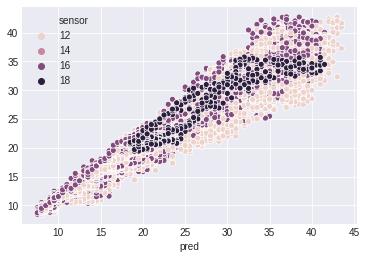

In [0]:
betas = [trace['_beta_{}'.format(i)].mean(axis=0) for i in range(12)]
alpha = trace['alpha'].mean(axis=0)

pred = np.matmul(X, betas) + alpha
sns.scatterplot(df['value'], pred, hue=df['sensor'])
plt.xlabel('true')
plt.xlabel('pred')

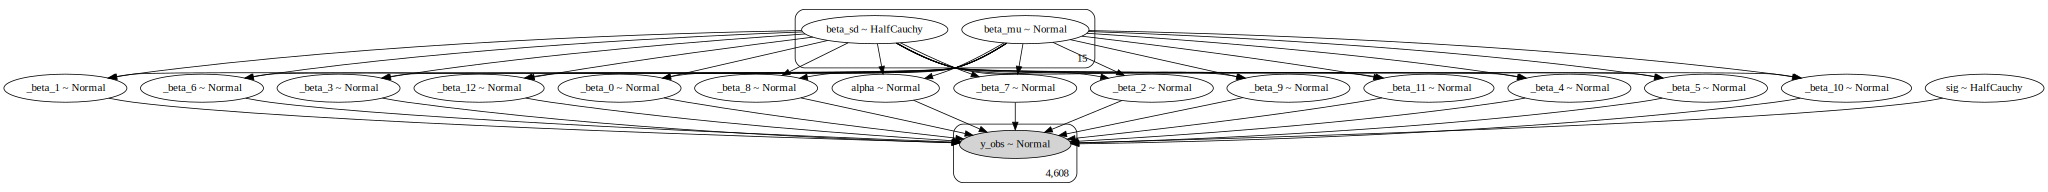

In [0]:
X = df[['mean_temp','12h_rain','diff_1t','diff_2t','diff_3t','diff_4t','diff_1h','diff_2h','diff_4h','diff_24h','day/night','X00X31','X07X28']]
# X['cycle'] = X['cycle'].astype('category')
# X = pd.get_dummies(X)
X = np.asarray(X)

with pm.Model() as model:
  
  beta_mu = pm.Normal('beta_mu', 0., 10., shape=15)
  beta_sd = pm.HalfCauchy('beta_sd', 10. , shape=15)
    
  # intercept
  alpha = pm.Normal('alpha', mu=beta_mu[0], sd=beta_sd[0])  
  # beta0 = pm.Normal('beta0', mu=beta_mu[1], sd=beta_sd[1])  

  beta_mat = [pm.Normal('_beta_{}'.format(i), mu=beta_mu[i+1], sd=beta_sd[i+1])  for i in range(13)]
  # beta = pm.Deterministic('beta', tt.stack(beta_mat, axis=1))
  
  theta = alpha  +pm.math.dot(X, beta_mat)
  sig = pm.HalfCauchy('sig' , 10)
  y_obs = pm.Normal('y_obs', mu= theta, sd=sig, observed=df['diff_temp'].values)

pm.model_to_graphviz(model)

In [0]:
with model:
  approx = pm.fit(method= 'advi', n=50000)
  trace = approx.sample(1000)

Average Loss = 9,191.1: 100%|██████████| 50000/50000 [01:02<00:00, 804.11it/s]
Finished [100%]: Average Loss = 9,191


Text(0.5, 0, 'pred')

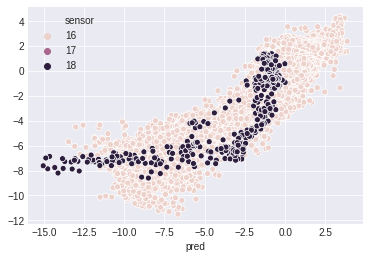

In [0]:
betas = [trace['_beta_{}'.format(i)].mean(axis=0) for i in range(13)]
alpha = trace['alpha'].mean(axis=0)

pred = np.matmul(X,betas) + alpha
sns.scatterplot(df['diff_temp'], pred, hue=df['sensor'])
plt.xlabel('true')
plt.xlabel('pred')

In [0]:
from sklearn.metrics import mean_squared_error as mse
mse(df['value'], pred)

2.898393305252789

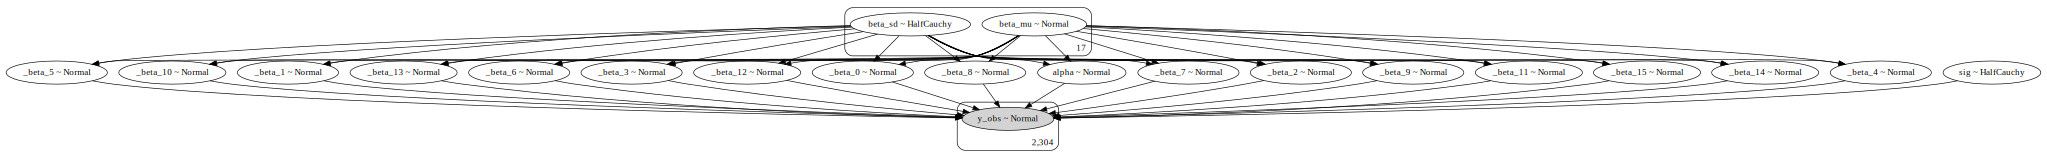

In [0]:
# model3 : partial pooling
# df = df.loc[df['sensor'].isin([18,12,16])]
df2['sensor'] = df2['sensor'].replace({1:0,2:1}).values
test['sensor'] = test['sensor'].replace({1:0,2:1}).values
# test['sensor'] = 2

X = df2[['X00X07','X00X28', 'X00X31', 'X00X32', 'X07X28', 'X07X31', 'X07X32', 'X28X31','X28X32', 'X31X32','mean-X00', 'mean-X07', 'mean-X28','mean-X31', 'mean-X32','day/night']]
# X['cycle'] = X['cycle'].astype('category')
# X = pd.get_dummies(X)
X = np.asarray(X)

test_x = test[['X00X07','X00X28', 'X00X31', 'X00X32', 'X07X28', 'X07X31', 'X07X32', 'X28X31','X28X32', 'X31X32','mean-X00', 'mean-X07', 'mean-X28','mean-X31', 'mean-X32','day/night']]
# test_x['cycle'] = test_x['cycle'].astype('category')
# test_x = pd.get_dummies(test_x)
test_x = np.asarray(test_x)

# n_dimension= X.shape[1]


## 
uniq = df2['sensor']
n_uniq = uniq.nunique()

with pm.Model() as model:
  


  beta_mu = pm.Normal('beta_mu', 0., 10., shape=17)
  beta_sd = pm.HalfCauchy('beta_sd', 10. , shape=17)
    
  # intercept
  alpha = pm.Normal('alpha', mu=beta_mu[0], sd=beta_sd[0], shape=n_uniq)  

  # coeff
  beta_mat = [pm.Normal('_beta_{}'.format(i), mu=beta_mu[i], sd=beta_sd[i])  for i in range(16)]
  # beta0 = pm.Normal('_beta_13', mu=beta_mu[12], sd=beta_sd[12], shape=n_uniq)
  # beta = pm.Deterministic('beta', tt.stack(beta_mat, axis=1))
  
  # theta = alpha[uniq] + beta_mat[0][uniq]+ beta_mat[1][uniq]+ beta_mat[2][uniq]+ beta_mat[3][uniq]+ beta_mat[4][uniq]+ beta_mat[5][uniq]+ beta_mat[6][uniq]+ beta_mat[7][uniq] + beta_mat[8][uniq] + beta_mat[9][uniq]
  theta = alpha[uniq]  + pm.math.dot(X, beta_mat) 
  sig = pm.HalfCauchy('sig' , 10)

  y_obs = pm.Normal('y_obs', mu= theta, sd=sig, observed=df2['diff_temp'].values)

pm.model_to_graphviz(model)

In [0]:
with model:
  approx = pm.fit(method='advi', n=50000)
  trace = approx.sample(1000)

Average Loss = 3,813.8: 100%|██████████| 50000/50000 [01:34<00:00, 528.12it/s]
Finished [100%]: Average Loss = 3,813.7


In [0]:
betas = [trace['_beta_{}'.format(i)].mean(axis=0) for i in range(15)]
# alpha = trace['alpha'].mean(axis=0)
# beta0 = dict(zip(range(3), [trace['_beta_13'][:,i].mean(axis=0) for i in range(3)]))
alpha = dict(zip(range(2), [trace['alpha'][:,i].mean(axis=0) for i in range(2)]))

pred =  np.matmul(X, betas) + (df2['sensor']).replace(alpha).values
# pred_test = np.matmul(test_x, betas) + (test['sensor']).replace(alpha).values
sns.scatterplot(df2['diff_temp'], pred, hue=df['sensor'])
xvals = np.linspace(-10,10,200)
plt.plot(xvals,xvals, c='r', ls='--')
# plt.xlabel('true')
# plt.xlabel('pred')

IndexError: ignored

In [0]:
from sklearn.metrics import mean_squared_error as mse
mse(df['diff_temp'], pred)


In [0]:
df.columns[-20:]

Index(['cumsum_24h', 'diff_1mean_sun', 'diff_1mean_rain', '12h_rain', 'X00X07',
       'X00X28', 'X00X31', 'X00X32', 'X07X28', 'X07X31', 'X07X32', 'X28X31',
       'X28X32', 'X31X32', 'diff_temp', 'mean-X00', 'mean-X07', 'mean-X28',
       'mean-X31', 'mean-X32'],
      dtype='object')

In [0]:
df1= df[df['day/night']==0]
df2= df[df['day/night']==1]

In [0]:
df

## test

* x,y, 좌표공간
* 23개의 센서
* obs = correlation값, 거리 measure
* 센서 2
* 

In [0]:
dff = df.loc[df['sensor']==18]
X = dff[['mean_temp','X00X07','X00X28', 'X00X31', 'X00X32', 'X07X28', 'X07X31', 'X07X32', 'X28X31','X28X32', 'X31X32','mean-X00', 'mean-X07', 'mean-X28','mean-X31', 'mean-X32','day/night']]
X = np.asarray(X)

with pm.Model() as model:
  beta_mu = pm.Normal('beta_mu', 0., 10., shape=18)
  beta_sd = pm.HalfCauchy('beta_sd', 10. , shape=18)
    
  # intercept
  alpha = pm.Normal('alpha', mu=beta_mu[0], sd=beta_sd[0])  

  # coeff
  beta_mat = [pm.Normal('_beta_{}'.format(i), mu=beta_mu[i+1], sd=beta_sd[i+1])  for i in range(17)]
  
  
  
  theta = alpha + pm.math.dot(X, beta_mat) 
  sig = pm.HalfCauchy('sig' , 10)

  y_obs = pm.Normal('y_obs', mu= theta, sd=sig, observed=dff['value'].values)

In [0]:
with model:
  approx = pm.fit(method='advi', n=50000)
  trace = approx.sample(1000)

Average Loss = 1,141.1: 100%|██████████| 50000/50000 [00:34<00:00, 1457.35it/s]
Finished [100%]: Average Loss = 1,141.1


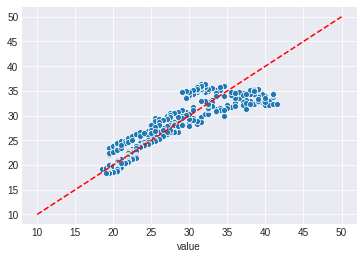

In [0]:
betas = [trace['_beta_{}'.format(i)].mean(axis=0) for i in range(17)]
alpha = trace['alpha'].mean(axis=0)
# beta0 = dict(zip(range(3), [trace['_beta_13'][:,i].mean(axis=0) for i in range(3)]))
# alpha = dict(zip(range(2), [trace['alpha'][:,i].mean(axis=0) for i in range(2)]))

pred =  np.matmul(X, betas) + alpha
# pred_test = np.matmul(test_x, betas) + (test['sensor']).replace(alpha).values
sns.scatterplot(dff['value'], pred)
xvals = np.linspace(10,50,200)
plt.plot(xvals,xvals, c='r', ls='--')


In [0]:
mse(dff['value'], pred)

6.813108658803027